<a href="https://colab.research.google.com/github/entc-17-fyp-20/WPF_Data_Visualization/blob/Kusal/CNN_forecasted_power_10_seconds_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dilated CNN model**



*   Prepare time series data for training a Convolutional Neural Network (CNN) forecasting model
*   Implement a CNN model in keras to predict the next step ahead (time t+1) in the time series


*   Enable early stopping to reduce the likelihood of model overfitting
*   Evaluate the model on a test dataset

In here we are using dilated CNN model with 3 convolutional layers.

# **SETUP**

In [ ]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from glob import glob
from IPython.display import Image
%matplotlib inline
import plotly.express as px
import io


pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

url1 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/S6%2010%20seconed%20data.csv' #S6 10 seconed data.csv
url2 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/AE59_1.csv' #AE59_1
url3 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/AE59_2.csv' #AE59_2
url4 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V08%20June%2010%20sec%20data.csv' #V08 June 10 sec data.csv; does not contain current columns
url5 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20June%2010%20sec%20data.csv' #V13 June 10 sec data.csv
url6 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V08%20July%2010%20sec%20data.csv' #V08 July 10 sec data.csv
url7 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20July%2010%20sec%20data.csv' #V13 July 10 sec data.csv
url8 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/Mannar.csv'  #Mannar dataset-10_min-wind_speed.csv
url9 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/Mannar%20full%20data.csv' #Mannar full data set.csv
df = pd.read_csv(url1)

In [ ]:
df=pd.DataFrame(df)
df

,Date & Time,Frequency Hz,Voltage R Phase V,Voltage S Phase V,Voltage T Phase V,Current R Phase A,Current S Phase A,Current T Phase A,Wind Speed m/s,Active Power kW,Reactive Power kVAR,Generator RPM,Hydraulic unit Pressure in bar,Ambient Temperature,Nacelle Temperature,Gearbox oil Temperature,Gearbox Bearing Temperature,Generator Winding Temperature R,Generator Winding Temperature S,Generator Winding Temperature T,Hydraulic oil Temperature,Main bearing Temperature,Generator Bearing Temperature DE,Generator Bearing Temperature NDE
0,FECHA_HORA,SSV_5SM_006_XS_FRQ_MEDI,SSV_5SM_006_XS_TNS_FASR,SSV_5SM_006_XS_TNS_FASS,SSV_5SM_006_XS_TNS_FAST,SSV_5SM_006_XS_INT_FASR,SSV_5SM_006_XS_INT_FASS,SSV_5SM_006_XS_INT_FAST,SSV_5SM_006_XS_VEL_WIND,SSV_5SM_006_XS_POT_MEDI,SSV_5SM_006_XS_POT_REAC,SSV_5SM_006_XS_VEL_LGMD,SSV_5SM_006_XS_PRS_PRPL,SSV_5SM_006_XS_TMP_0004,SSV_5SM_006_XS_TMP_V006,SSV_5SM_006_XS_TMP_V007,SSV_5SM_006_XS_TMP_V008,SSV_5SM_006_XS_TMP_V003,SSV_5SM_006_XS_TMP_V004,SSV_5SM_006_XS_TMP_V005,SSV_5SM_006_XS_TMP_V002,SSV_5SM_006_XS_TMP_V001,SSV_5SM_006_XS_TMP_0008,SSV_5SM_006_XS_TMP_0007
1,24/06/2021 00:00:00,50.27,590.5,588.6,585.7,435.7,427.5,426.6,10.4,737.8,1.3,1486.6,166.7,31.6,34.2,70.2,79.7,139.9,132.9,138.1,53.3,43.9,74.6,72.4
2,24/06/2021 00:00:10,50.26,585.6,587.4,591.3,418.9,413.6,410.7,11.4,745.5,1.7,1482.2,180.3,31.4,34.3,69.5,79.9,139.1,132.5,138.1,53.6,43.8,74.5,72.6
3,24/06/2021 00:00:20,50.24,591.8,589.5,586.5,429.8,425.6,421.3,10.2,732.7,8.2,1500,166.8,31.4,34.3,69.6,79.9,139.8,133.4,138.2,53.6,43.9,74.5,72.7
4,24/06/2021 00:00:30,50.22,591.1,588.5,584.5,425.9,427.1,441.2,10.1,743.1,8.4,1493.2,167.4,31.4,34.3,70.2,79.7,139.5,133.2,137.8,53.7,43.9,74.6,72.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8636,24/06/2021 23:59:10,50.04,581.8,580.3,581.1,236.1,237,236.7,7.9,404.2,-7.2,1468.4,179.8,31,32.3,60.8,73.4,95.2,90.9,95.9,53.6,43.7,61.8,65.4
8637,24/06/2021 23:59:20,50.12,580.4,581,583.2,217.6,221.4,220.9,7.4,367.3,8.5,1426.5,162.7,31,32.3,61.3,73.8,95,89.4,95,53.6,43.7,61.8,65.2
8638,24/06/2021 23:59:30,50.08,578.3,583.7,580.9,195.9,196.9,191.6,7.7,329.3,-23.3,1425.1,169.7,31,32.2,60.5,73.6,94,90.4,94.1,53.8,43.7,61.9,65.3
8639,24/06/2021 23:59:40,50.1,582.5,577.5,576.7,270.7,272.2,268,8.4,465.7,-0.8,1512.8,177.4,30.9,32.2,61.4,73.6,95.2,90.7,94.9,53.7,43.6,62,65.3


In [ ]:
df=df.drop(0)

In [ ]:
'''df['Date & Time'][0]="8/1/2021 0:00"
df['Date & Time'][4408]="9/1/2021  0:00"
df'''


'df[\'Date & Time\'][0]="8/1/2021 0:00"\ndf[\'Date & Time\'][4408]="9/1/2021  0:00"\ndf'

In [ ]:
df=df.set_index('Date & Time')
df

,Frequency Hz,Voltage R Phase V,Voltage S Phase V,Voltage T Phase V,Current R Phase A,Current S Phase A,Current T Phase A,Wind Speed m/s,Active Power kW,Reactive Power kVAR,Generator RPM,Hydraulic unit Pressure in bar,Ambient Temperature,Nacelle Temperature,Gearbox oil Temperature,Gearbox Bearing Temperature,Generator Winding Temperature R,Generator Winding Temperature S,Generator Winding Temperature T,Hydraulic oil Temperature,Main bearing Temperature,Generator Bearing Temperature DE,Generator Bearing Temperature NDE
Date & Time,,,,,,,,,,,,,,,,,,,,,,,
24/06/2021 00:00:00,50.27,590.5,588.6,585.7,435.7,427.5,426.6,10.4,737.8,1.3,1486.6,166.7,31.6,34.2,70.2,79.7,139.9,132.9,138.1,53.3,43.9,74.6,72.4
24/06/2021 00:00:10,50.26,585.6,587.4,591.3,418.9,413.6,410.7,11.4,745.5,1.7,1482.2,180.3,31.4,34.3,69.5,79.9,139.1,132.5,138.1,53.6,43.8,74.5,72.6
24/06/2021 00:00:20,50.24,591.8,589.5,586.5,429.8,425.6,421.3,10.2,732.7,8.2,1500,166.8,31.4,34.3,69.6,79.9,139.8,133.4,138.2,53.6,43.9,74.5,72.7
24/06/2021 00:00:30,50.22,591.1,588.5,584.5,425.9,427.1,441.2,10.1,743.1,8.4,1493.2,167.4,31.4,34.3,70.2,79.7,139.5,133.2,137.8,53.7,43.9,74.6,72.7
24/06/2021 00:00:40,50.31,593.3,585.5,589.4,421.5,421.2,430.8,10.5,744,3.8,1529.8,180,31.5,34.2,70,79.6,139.2,133.6,137.3,53.7,43.8,74.3,72.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24/06/2021 23:59:10,50.04,581.8,580.3,581.1,236.1,237,236.7,7.9,404.2,-7.2,1468.4,179.8,31,32.3,60.8,73.4,95.2,90.9,95.9,53.6,43.7,61.8,65.4
24/06/2021 23:59:20,50.12,580.4,581,583.2,217.6,221.4,220.9,7.4,367.3,8.5,1426.5,162.7,31,32.3,61.3,73.8,95,89.4,95,53.6,43.7,61.8,65.2
24/06/2021 23:59:30,50.08,578.3,583.7,580.9,195.9,196.9,191.6,7.7,329.3,-23.3,1425.1,169.7,31,32.2,60.5,73.6,94,90.4,94.1,53.8,43.7,61.9,65.3


In [ ]:
df.describe()

,Frequency Hz,Voltage R Phase V,Voltage S Phase V,Voltage T Phase V,Current R Phase A,Current S Phase A,Current T Phase A,Wind Speed m/s,Active Power kW,Reactive Power kVAR,Generator RPM,Hydraulic unit Pressure in bar,Ambient Temperature,Nacelle Temperature,Gearbox oil Temperature,Gearbox Bearing Temperature,Generator Winding Temperature R,Generator Winding Temperature S,Generator Winding Temperature T,Hydraulic oil Temperature,Main bearing Temperature,Generator Bearing Temperature DE,Generator Bearing Temperature NDE
count,8640,8640,8640,8640,8640,8640,8640,8640,8640,8640,8640,8640,8640,8640,8640,8640,8640,8640,8640,8640,8640,8640,8640
unique,42,345,328,327,2786,2760,2756,66,4092,515,418,207,28,34,126,103,569,542,547,28,12,176,163
top,50.06,587.7,585.8,582.4,426.9,427.5,416.9,9.8,729.9,1.1,1499.2,171.4,31.2,32.6,69.4,79.1,142.9,136.1,140.9,54.3,43.9,61.5,74.6
freq,654,66,64,73,22,20,23,501,14,64,141,79,905,876,203,214,47,63,55,775,1425,160,200


**Data set plot**

In [ ]:
fig = px.line(df,x=df.index, y='Active Power kW') 
fig.show()

# **Train, validation and test sets**
We separate our dataset into train, validation and test sets.

*   We train the model on the train set.
*   The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data.
*   After the model has finished training, we evaluate the model on the test set.

We will allocate last 5% of the data set as test data and 5% before test data as validation data.All the other data will be training data.





In [ ]:
L=len(df)
valid_start=int(18*L/20)
test_start=int(19*L/20)

train,valid,test=df[:valid_start],df[valid_start:test_start],df[test_start:L]  #seperate train and test data arrays
print(train.shape)
print(valid.shape)
print(test.shape)

print(train.describe())
print(valid.describe())
print(test.describe())

(7776, 23)
(432, 23)
(432, 23)
       Frequency Hz  ... Generator Bearing Temperature NDE
count          7776  ...                              7776
unique           42  ...                               153
top           50.06  ...                              74.6
freq            599  ...                               200

[4 rows x 23 columns]
       Frequency Hz  ... Generator Bearing Temperature NDE
count           432  ...                               432
unique           25  ...                                12
top           50.14  ...                              65.3
freq             38  ...                               118

[4 rows x 23 columns]
       Frequency Hz  ... Generator Bearing Temperature NDE
count           432  ...                               432
unique           22  ...                                 8
top           50.08  ...                              65.1
freq             56  ...                               127

[4 rows x 23 columns]


In [ ]:
train

,Frequency Hz,Voltage R Phase V,Voltage S Phase V,Voltage T Phase V,Current R Phase A,Current S Phase A,Current T Phase A,Wind Speed m/s,Active Power kW,Reactive Power kVAR,Generator RPM,Hydraulic unit Pressure in bar,Ambient Temperature,Nacelle Temperature,Gearbox oil Temperature,Gearbox Bearing Temperature,Generator Winding Temperature R,Generator Winding Temperature S,Generator Winding Temperature T,Hydraulic oil Temperature,Main bearing Temperature,Generator Bearing Temperature DE,Generator Bearing Temperature NDE
Date & Time,,,,,,,,,,,,,,,,,,,,,,,
24/06/2021 00:00:00,50.27,590.5,588.6,585.7,435.7,427.5,426.6,10.4,737.8,1.3,1486.6,166.7,31.6,34.2,70.2,79.7,139.9,132.9,138.1,53.3,43.9,74.6,72.4
24/06/2021 00:00:10,50.26,585.6,587.4,591.3,418.9,413.6,410.7,11.4,745.5,1.7,1482.2,180.3,31.4,34.3,69.5,79.9,139.1,132.5,138.1,53.6,43.8,74.5,72.6
24/06/2021 00:00:20,50.24,591.8,589.5,586.5,429.8,425.6,421.3,10.2,732.7,8.2,1500,166.8,31.4,34.3,69.6,79.9,139.8,133.4,138.2,53.6,43.9,74.5,72.7
24/06/2021 00:00:30,50.22,591.1,588.5,584.5,425.9,427.1,441.2,10.1,743.1,8.4,1493.2,167.4,31.4,34.3,70.2,79.7,139.5,133.2,137.8,53.7,43.9,74.6,72.7
24/06/2021 00:00:40,50.31,593.3,585.5,589.4,421.5,421.2,430.8,10.5,744,3.8,1529.8,180,31.5,34.2,70,79.6,139.2,133.6,137.3,53.7,43.8,74.3,72.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24/06/2021 21:35:10,50,570.1,571,569.9,183.1,184.3,182.5,7.2,306.8,2.9,1388.2,159.9,31.3,32.8,61.9,73.5,93,88.7,93.3,54.1,43.9,60.9,66.1
24/06/2021 21:35:20,49.98,573.9,567.1,566.8,181.6,181,182.8,6.9,268.6,4.9,1361.1,171.7,31.3,32.8,61.8,73.3,93.3,88.8,93.2,54.3,43.8,60.9,66
24/06/2021 21:35:30,50,572.4,566.8,572.3,171.9,172.3,170.7,7.1,262,-3.5,1345.8,175.1,31.3,32.7,61.3,73.7,94.8,89,93,54.4,43.8,61.1,65.9


In [ ]:
#date_time = pd.to_datetime(df_new['Date & Time'], format='%m/%d/%Y %H:%M')

# **Data preparation - training data**

I will get the input for each sample is a vector of previous **T lagged values**

**HORIZON=1** specifies that we have a forecasting horizon of 1 (t+1)

In [ ]:
T = 10
HORIZON = 1

**Scale the time series within [0,1]**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train=pd.DataFrame(train['Active Power kW'])
train['Active Power kW'] = scaler.fit_transform(train)
train.head(10)

,Active Power kW
Date & Time,
24/06/2021 00:00:00,0.90
24/06/2021 00:00:10,0.91
24/06/2021 00:00:20,0.89
24/06/2021 00:00:30,0.91
24/06/2021 00:00:40,0.91
24/06/2021 00:00:50,0.84
24/06/2021 00:01:00,0.95
24/06/2021 00:01:10,0.86
24/06/2021 00:01:20,0.89



**Original vs scaled data:**

In [ ]:
'''df[df.index < valid_start+1][["Average Wind Speed (m/s)"]].rename(columns={"Average Wind Speed (m/s)":'original wind speed'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={"Average Wind Speed (m/s)":'scaled wind speed'}).plot.hist(bins=100, fontsize=12)
plt.show()'''

'df[df.index < valid_start+1][["Average Wind Speed (m/s)"]].rename(columns={"Average Wind Speed (m/s)":\'original wind speed\'}).plot.hist(bins=100, fontsize=12)\ntrain.rename(columns={"Average Wind Speed (m/s)":\'scaled wind speed\'}).plot.hist(bins=100, fontsize=12)\nplt.show()'

**Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example**

In [ ]:
train_shifted = train.copy()
for i in range (1,HORIZON+1):
  train_shifted['y_t+'+str(i)] = train_shifted['Active Power kW'].shift(-i)
train_shifted.head(10)

,Active Power kW,y_t+1
Date & Time,,
24/06/2021 00:00:00,0.90,0.91
24/06/2021 00:00:10,0.91,0.89
24/06/2021 00:00:20,0.89,0.91
24/06/2021 00:00:30,0.91,0.91
24/06/2021 00:00:40,0.91,0.84
24/06/2021 00:00:50,0.84,0.95
24/06/2021 00:01:00,0.95,0.86
24/06/2021 00:01:10,0.86,0.89
24/06/2021 00:01:20,0.89,0.88


**Get T no of lagged values**

In [ ]:
for t in range(1, T+1):
    train_shifted['active_power_t-'+str(T-t)] = train_shifted['Active Power kW'].shift(T-t)
train_shifted = train_shifted.rename(columns={'Active Power kW':'Original_active_power'})
train_shifted.head(10)

,Original_active_power,y_t+1,active_power_t-9,active_power_t-8,active_power_t-7,active_power_t-6,active_power_t-5,active_power_t-4,active_power_t-3,active_power_t-2,active_power_t-1,active_power_t-0
Date & Time,,,,,,,,,,,,
24/06/2021 00:00:00,0.90,0.91,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.90
24/06/2021 00:00:10,0.91,0.89,nan,nan,nan,nan,nan,nan,nan,nan,0.90,0.91
24/06/2021 00:00:20,0.89,0.91,nan,nan,nan,nan,nan,nan,nan,0.90,0.91,0.89
24/06/2021 00:00:30,0.91,0.91,nan,nan,nan,nan,nan,nan,0.90,0.91,0.89,0.91
24/06/2021 00:00:40,0.91,0.84,nan,nan,nan,nan,nan,0.90,0.91,0.89,0.91,0.91
24/06/2021 00:00:50,0.84,0.95,nan,nan,nan,nan,0.90,0.91,0.89,0.91,0.91,0.84
24/06/2021 00:01:00,0.95,0.86,nan,nan,nan,0.90,0.91,0.89,0.91,0.91,0.84,0.95
24/06/2021 00:01:10,0.86,0.89,nan,nan,0.90,0.91,0.89,0.91,0.91,0.84,0.95,0.86
24/06/2021 00:01:20,0.89,0.88,nan,0.90,0.91,0.89,0.91,0.91,0.84,0.95,0.86,0.89


In [ ]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,Original_active_power,y_t+1,active_power_t-9,active_power_t-8,active_power_t-7,active_power_t-6,active_power_t-5,active_power_t-4,active_power_t-3,active_power_t-2,active_power_t-1,active_power_t-0
Date & Time,,,,,,,,,,,,
24/06/2021 00:01:30,0.88,0.86,0.90,0.91,0.89,0.91,0.91,0.84,0.95,0.86,0.89,0.88
24/06/2021 00:01:40,0.86,0.92,0.91,0.89,0.91,0.91,0.84,0.95,0.86,0.89,0.88,0.86
24/06/2021 00:01:50,0.92,0.90,0.89,0.91,0.91,0.84,0.95,0.86,0.89,0.88,0.86,0.92
24/06/2021 00:02:00,0.90,0.89,0.91,0.91,0.84,0.95,0.86,0.89,0.88,0.86,0.92,0.90
24/06/2021 00:02:10,0.89,0.93,0.91,0.84,0.95,0.86,0.89,0.88,0.86,0.92,0.90,0.89


**Convert the target variable into a numpy array(vector format)**

In [ ]:
y_train = np.array(train_shifted[["y_t+1"]])

In [ ]:
y_train.shape

(7766, 1)

In [ ]:
y_train

array([[0.86],
       [0.92],
       [0.9 ],
       ...,
       [0.13],
       [0.18],
       [0.21]])

**Convert the inputs into a numpy array with shape (samples, time steps, features)**

In [ ]:
X_train=np.array(train_shifted[['active_power_t-'+str(T-t) for t in range(1, T+1)]])
X_train = X_train[... , np.newaxis]


In [ ]:
X_train.shape

(7766, 10, 1)

In [ ]:
X_train[1]

array([[0.91],
       [0.89],
       [0.91],
       [0.91],
       [0.84],
       [0.95],
       [0.86],
       [0.89],
       [0.88],
       [0.86]])

# **Data preparation - validation set**

In [ ]:
valid=pd.DataFrame(valid['Active Power kW'])
valid

,Active Power kW
Date & Time,
24/06/2021 21:36:00,252.6
24/06/2021 21:36:10,239
24/06/2021 21:36:20,237.8
24/06/2021 21:36:30,240
24/06/2021 21:36:40,259.1
...,...
24/06/2021 22:47:10,344.5
24/06/2021 22:47:20,344.5
24/06/2021 22:47:30,354.7


In [ ]:
valid_new=df[valid_start-T+1:test_start]
valid_new=pd.DataFrame(valid_new['Active Power kW'])
valid_new.head(20)

,Active Power kW
Date & Time,
24/06/2021 21:34:30,292.2
24/06/2021 21:34:40,248.4
24/06/2021 21:34:50,276.2
24/06/2021 21:35:00,316.3
24/06/2021 21:35:10,306.8
24/06/2021 21:35:20,268.6
24/06/2021 21:35:30,262
24/06/2021 21:35:40,294.8
24/06/2021 21:35:50,313.7


In [ ]:
valid_new['Active Power kW']=scaler.transform(valid_new)
valid_new.head()

,Active Power kW
Date & Time,
24/06/2021 21:34:30,0.18
24/06/2021 21:34:40,0.11
24/06/2021 21:34:50,0.15
24/06/2021 21:35:00,0.22
24/06/2021 21:35:10,0.20


In [ ]:
valid_shifted = valid_new.copy()
valid_shifted['y_t+1'] = valid_shifted['Active Power kW'].shift(-HORIZON)
valid_shifted.head(10)

for t in range(1, T+1):
    valid_shifted['active_power_t-'+str(T-t)] = valid_shifted['Active Power kW'].shift(T-t)
vali_shifted = valid_shifted.rename(columns={'Active Power kW':'Original_active_power'})

valid_shifted = valid_shifted.dropna(how='any')
y_valid = np.array(valid_shifted[["y_t+1"]])
X_valid=np.array(valid_shifted[['active_power_t-'+str(T-t) for t in range(1, T+1)]])
X_valid = X_valid[... , np.newaxis]

In [ ]:
y_valid.shape

(431, 1)

In [ ]:
X_valid.shape

(431, 10, 1)

# **Implement the Convolutional Neural Network**
We implement the convolutional neural network with 3 layers, 5 neurons in each layer, a kernel size of 3 in each layer, and dilation rates of 1, 2 and 4 for each successive layer.

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
LATENT_DIM = 10
KERNEL_SIZE = 2
BATCH_SIZE = 32
EPOCHS = 30

In [ ]:
model = Sequential()
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(T, 1)))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
#model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=8))
model.add(Flatten())
model.add(Dense(HORIZON, activation='linear'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 10)            30        
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 10)            210       
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 10)            210       
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 551
Trainable params: 551
Non-trainable params: 0
_________________________________________________________________


Use Adam optimizer and mean squared error as the loss function.

In [ ]:
model.compile(optimizer='Adam', loss='mse')

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [ ]:
best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [ ]:
history = model.fit(X_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/30
243/243 [==============================] - 2s 3ms/step - loss: 0.0560 - val_loss: 0.0128
Epoch 2/30
243/243 [==============================] - 1s 3ms/step - loss: 0.0125 - val_loss: 0.0070
Epoch 3/30
243/243 [==============================] - 1s 3ms/step - loss: 0.0096 - val_loss: 0.0065
Epoch 4/30
243/243 [==============================] - 1s 3ms/step - loss: 0.0085 - val_loss: 0.0053
Epoch 5/30
243/243 [==============================] - 1s 3ms/step - loss: 0.0081 - val_loss: 0.0051
Epoch 6/30
243/243 [==============================] - 1s 3ms/step - loss: 0.0080 - val_loss: 0.0049
Epoch 7/30
243/243 [==============================] - 1s 2ms/step - loss: 0.0078 - val_loss: 0.0049
Epoch 8/30
243/243 [==============================] - 1s 3ms/step - loss: 0.0077 - val_loss: 0.0049
Epoch 9/30
243/243 [==============================] - 1s 3ms/step - loss: 0.0076 - val_loss: 0.0050
Epoch 10/30
243/243 [==============================] - 1s 3ms/step - loss: 0.0077 - val_loss: 0.0047

Load the model with the smallest mape

In [ ]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

plot training and validation losses

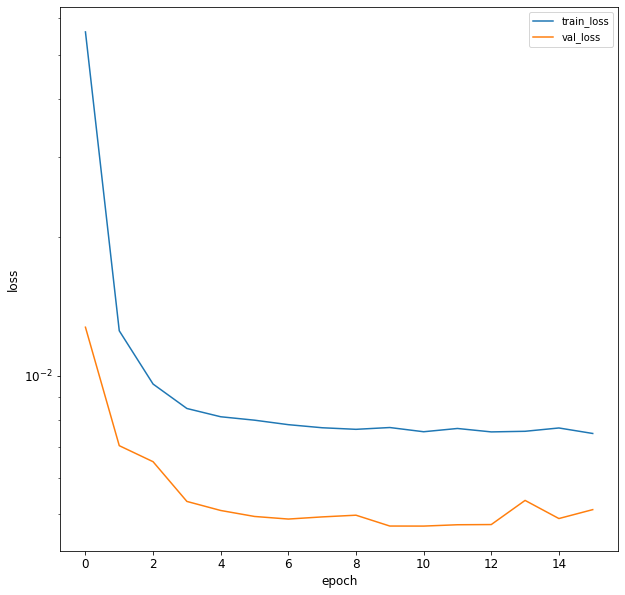

In [ ]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

# **Evaluate the model** 

**Create the test set**

In [ ]:
#test_forecasted=pd.DataFrame(test[' Forecasted Power (kW) '])
test=pd.DataFrame(test['Active Power kW'])
#print(test_forecasted)
test

,Active Power kW
Date & Time,
24/06/2021 22:48:00,440.4
24/06/2021 22:48:10,414.4
24/06/2021 22:48:20,377.4
24/06/2021 22:48:30,357.2
24/06/2021 22:48:40,381.6
...,...
24/06/2021 23:59:10,404.2
24/06/2021 23:59:20,367.3
24/06/2021 23:59:30,329.3


In [ ]:
test_new=df[test_start-T+1:L]
test_new=pd.DataFrame(test_new['Active Power kW'])
test_new.head(20)

,Active Power kW
Date & Time,
24/06/2021 22:46:30,391.5
24/06/2021 22:46:40,404.1
24/06/2021 22:46:50,400.7
24/06/2021 22:47:00,400.2
24/06/2021 22:47:10,344.5
24/06/2021 22:47:20,344.5
24/06/2021 22:47:30,354.7
24/06/2021 22:47:40,370.4
24/06/2021 22:47:50,417.1


**Scale tht test data**

In [ ]:
test_new['Active Power kW']=scaler.transform(test_new)
test_new.head()

,Active Power kW
Date & Time,
24/06/2021 22:46:30,0.34
24/06/2021 22:46:40,0.36
24/06/2021 22:46:50,0.35
24/06/2021 22:47:00,0.35
24/06/2021 22:47:10,0.26


**Create test set features**

In [ ]:
test_shifted = test_new.copy()
test_shifted['y_t+1'] = test_shifted['Active Power kW'].shift(-HORIZON)
print(test_shifted)

for t in range(1, T+1):
    test_shifted['active_power_t-'+str(T-t)] = test_shifted['Active Power kW'].shift(T-t)
test_shifted = test_shifted.rename(columns={'Active Power kW':'Original_active_power'})

test_shifted = test_shifted.dropna(how='any')
y_test = np.array(test_shifted[['Original_active_power']])
X_test=np.array(test_shifted[['active_power_t-'+str(T-t) for t in range(1, T+1)]])
X_test = X_test[... , np.newaxis]

                     Active Power kW  y_t+1
Date & Time                                
24/06/2021 22:46:30             0.34   0.36
24/06/2021 22:46:40             0.36   0.35
24/06/2021 22:46:50             0.35   0.35
24/06/2021 22:47:00             0.35   0.26
24/06/2021 22:47:10             0.26   0.26
...                              ...    ...
24/06/2021 23:59:10             0.36   0.30
24/06/2021 23:59:20             0.30   0.24
24/06/2021 23:59:30             0.24   0.46
24/06/2021 23:59:40             0.46   0.49
24/06/2021 23:59:50             0.49    nan

[441 rows x 2 columns]


**Make predictions on test set**

In [ ]:
predictions = model.predict(X_test)
#predictions

In [ ]:
predictions=pd.DataFrame(predictions)
predictions

,0
0,0.40
1,0.36
2,0.32
3,0.29
4,0.32
...,...
426,0.31
427,0.37
428,0.30
429,0.27


In [ ]:
forecasted_values=np.array(test_forecasted[' Forecasted Power (kW) '])
forecasted_values=pd.DataFrame(forecasted_values)
forecasted_values

,0
0,56.01
1,57.30
2,61.88
3,63.02
4,63.60
...,...
216,101.74
217,101.78
218,101.85
219,101.29


**Compare predictions to actual wind speed**

In [ ]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df['prediction'] =predictions 
#eval_df['forecasted_values']=forecasted_values
eval_df
#eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
#eval_df

,timestamp,h,prediction,actual
0,24/06/2021 22:48:00,t+1,0.40,0.42
1,24/06/2021 22:48:10,t+1,0.36,0.38
2,24/06/2021 22:48:20,t+1,0.32,0.32
3,24/06/2021 22:48:30,t+1,0.29,0.28
4,24/06/2021 22:48:40,t+1,0.32,0.32
...,...,...,...,...
426,24/06/2021 23:59:00,t+1,0.31,0.29
427,24/06/2021 23:59:10,t+1,0.37,0.36
428,24/06/2021 23:59:20,t+1,0.30,0.30
429,24/06/2021 23:59:30,t+1,0.27,0.24


In [ ]:
eval_df[['prediction']]=scaler.inverse_transform(np.array(eval_df[['prediction']]))
eval_df[['actual']]=scaler.inverse_transform(np.array(eval_df[['actual']]))
eval_df[['Our_prediction_diff']]=np.abs(eval_df['prediction']-eval_df['actual'])
#eval_df[['CEB_prediction_diff']]=np.abs(eval_df['forecasted_values']-eval_df['actual'])
eval_df['our_rs_eror']=np.sqrt(np.abs(eval_df['prediction']-eval_df['actual']))
#eval_df['rs_error']=np.sqrt(np.abs(eval_df['forecasted_values']-eval_df['actual']))
#eval_df[['prediction']].shape
eval_df

,timestamp,h,prediction,actual,Our_prediction_diff,our_rs_eror
0,24/06/2021 22:48:00,t+1,426.92,440.40,13.48,3.67
1,24/06/2021 22:48:10,t+1,406.89,414.40,7.51,2.74
2,24/06/2021 22:48:20,t+1,382.26,377.40,4.86,2.21
3,24/06/2021 22:48:30,t+1,364.31,357.20,7.11,2.67
4,24/06/2021 22:48:40,t+1,383.16,381.60,1.56,1.25
...,...,...,...,...,...,...
426,24/06/2021 23:59:00,t+1,375.07,360.60,14.47,3.80
427,24/06/2021 23:59:10,t+1,414.08,404.20,9.88,3.14
428,24/06/2021 23:59:20,t+1,370.56,367.30,3.26,1.81
429,24/06/2021 23:59:30,t+1,351.15,329.30,21.85,4.67


MAPE of our prediction

In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

actual = eval_df['actual']
pred = eval_df['prediction']

mape(actual, pred)

3.4454590834581826

MAPE of CEB preictions

In [ ]:
def mape(actual, forecasted): 
    actual, pred = np.array(actual), np.array(forecasted)
    return np.mean(np.abs((actual - forecasted) / actual)) * 100

actual = eval_df['actual']
forecasted = eval_df['forecasted_values']

mape(actual, forecasted)

10.918870806377468

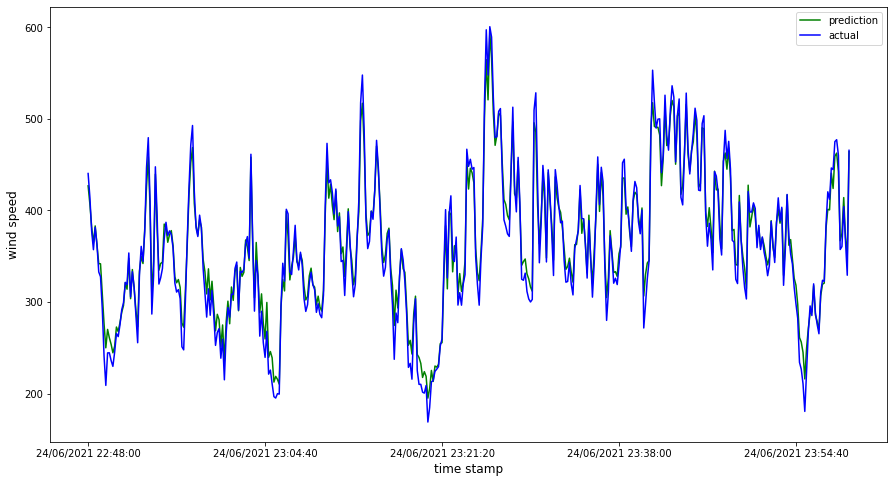

In [ ]:
eval_df[eval_df.timestamp<'24/06/2021 23:59:50'].plot(x='timestamp', y=['prediction', 'actual'], style=['g', 'b'], figsize=(15, 8))
plt.xlabel('time stamp', fontsize=12)
plt.ylabel('wind speed', fontsize=12)
plt.show()

#eval_df[eval_df.timestamp<'8/31/2021 23:50'].plot(x='timestamp', y=['forecasted_values', 'actual'], style=['r', 'b'], figsize=(15, 8))


**Clean up model files**

In [ ]:
for m in glob('model_*.h5'):
    os.remove(m)